# Pricing Elasticity of Demand

Let's take a look at the pricing elasticity of demand (PED) or $E_D$. The intuition behind $E_D$ is that is a measure of how sensitive demand is to price change. Typically, for a product, we can set the price $p_i$ and measure the amount of quantity $q_i$ sold, and these values form a pair $(p_i, q_i)$. If a product is sold at multiple prices, then we have multiple price-quantity pairs, $(p_1, q_1), (p_2, q_2), \ldots, (p_n, q_n)$. Plotting these pairs of points forms what is known as the `demand curve`.

Below is a fake dataset of prices and quantities.

In [18]:
import pandas as pd
import numpy as np

np.random.seed(37)

df = pd.DataFrame({
    'p': np.arange(1, 20, 1) + 1.99,
    'q': np.exp(-0.1 * np.arange(1, 20, 1)) * 100.0 
})

df

,p,q
0,2.99,90.483742
1,3.99,81.873075
2,4.99,74.081822
3,5.99,67.032005
4,6.99,60.653066
5,7.99,54.881164
6,8.99,49.658530
7,9.99,44.932896
8,10.99,40.656966
9,11.99,36.787944


We can plot this data into demand curves. The demand curve on the left plots the raw values while the demand curve on the right plots the log of the values.

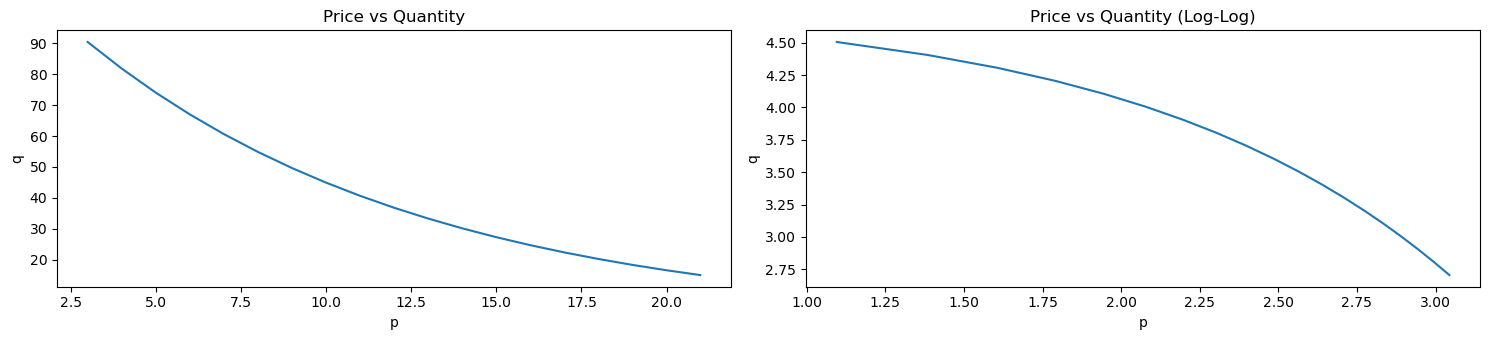

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

df \
    .set_index(['p'])['q'] \
    .plot(kind='line', ylabel='q', title='Price vs Quantity', ax=ax[0])
np.log(df) \
    .set_index(['p'])['q'] \
    .plot(kind='line', ylabel='q', title='Price vs Quantity (Log-Log)', ax=ax[1])

fig.tight_layout()

Formally, $E_D$ is defined as follows.

$\dfrac{\Delta Q}{\Delta P}$, where

- $\Delta Q$ is the percent change in quantity (eg the quantity of demand), and
- $\Delta P$ is the percent change in price.

Notice that $\Delta Q$ and $\Delta P$ are `percent changes`, not `absolute changes`. It's more clear if we write out $E_D$ as follows.

$\dfrac{\dfrac{\Delta Q}{Q}}{\dfrac{\Delta P}{P}} = \dfrac{\Delta Q}{Q} \dfrac{P}{\Delta P} = \dfrac{\Delta Q}{\Delta P} \dfrac{P}{Q}$

Let's focus on $\Delta Q$, which implies a difference between two quantites, $\Delta Q = q_i - q_j$. Also, $\Delta P$ implies the difference between two prices, $\Delta P = p_i - p_j$. It should be obvious that $q_i$ is the quantity/demand associated with the price $p_i$, and likewise, $q_j$ is the quantity/demand associated with the price $p_j$.

Ok, so $\Delta Q = q_i - q_j$, so what is $Q$ then--is it $q_i$ or $q_j$? Really, $Q = q_i$, and likewise, $P = p_i$ since we are moving from the point $(p_i, q_i)$ to the other point $(p_j, q_j)$. By now, you should know that $E_D$ is determined by two points, not a single point.

Ok, so if we are moving from a point $(p_i, q_i)$ to another point $(p_j, q_j)$ (meaning, we are changing the price from $p_i$ to $p_j$), then we can write $E_D$ to be even more clear as follows.

$\dfrac{\dfrac{q_i - q_j}{q_i}}{\dfrac{p_i - p_j}{p_i}} = \dfrac{q_i - q_j}{q_i} \dfrac{p_i}{p_i - p_j} = \dfrac{q_i - q_j}{p_i - p_j} \dfrac{p_i}{q_i}$

If instead we are going from $(p_j, q_j)$ to $(p_i, q_i)$, then $E_D$ will be written out as follows.

$\dfrac{\dfrac{q_j - q_i}{q_j}}{\dfrac{p_j - p_i}{p_j}} = \dfrac{q_j - q_i}{q_j} \dfrac{p_j}{p_j - p_i} = \dfrac{q_j - q_i}{p_j - p_i} \dfrac{p_j}{q_j}$

In general, we can go from any point to another (both points have to be on the demand curve, obviously) and compute $E_D$ with respect to the starting point. Note that $E_D^{ij}$ (going from point $i$ to point $j$) is different from $E_D^{ji}$ (going from point $j$ to point $i$). Additionally, even if the demand curve is linear, $E_D^{ij} \neq E_D^{ji}$.

Lastly, $E_D$ is typically negative, $E_D \leq 0$, but the interpretation of $E_D$ is based on its absolute value.

- $E_D = 0$ means perfectly inelastic,
- $0 < E_D < 1$ means relatively inelastic,
- $E_D = 1$ means unit elastic,
- $E_D > 1$ means relatively elastic, and
- $E_D = \infty$ means perfectly elastic.

Let's compute $E_D$ for all pairs of points on the demand curve above.

In [27]:
import itertools

def compute_elasticity(p_i, p_j, q_i, q_j):
    a = (q_i - q_j) / (p_i - p_j)
    b = p_i / q_j 
    
    return a * b

p2q = {np.log(r['p']): np.log(r['q']) for _, r in df.iterrows()}

price_pairs = np.log(df['p'].values)
price_pairs = itertools.product(price_pairs, price_pairs)
price_pairs = filter(lambda tup: tup[0] != tup[1], price_pairs)
price_pairs = list(price_pairs)

ped_df = pd.DataFrame([(p_i, p_j, p2q[p_i], p2q[p_j], compute_elasticity(p_i, p_j, p2q[p_i], p2q[p_j])) 
                       for p_i, p_j in price_pairs], columns=['p_i', 'p_j', 'q_i', 'q_j', 'ped'])

Let's visualize $E_D$ for all the pairs of points on the demand curve. Note that the size of the circle correlates with $|E_D^{ij}|$ and the color of the cirlce is red if $|E_D^{ij}| < 1$ and blue if $|E_D^{ij}| > 1$.

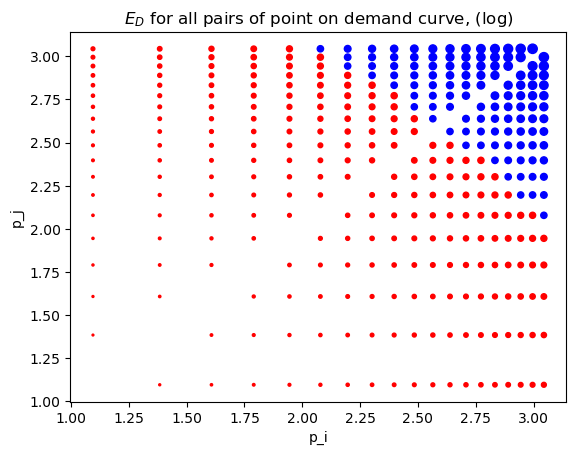

In [30]:
_ = ped_df.assign(s=lambda d: np.abs(d['ped']) * 20) \
    .plot(
        kind='scatter', 
        x='p_i', y='p_j', s='s', 
        color=np.abs(ped_df['ped']).apply(lambda v: 'r' if v < 1 else 'b'),
        title=r'$E_D$ for all pairs of point on demand curve, (log)'
    )

## Elasticity

In [3]:
_temp1 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den']
    )

In [4]:
_temp2 = df \
    .assign(
        q_p=lambda d: d['q'].shift(-1),
        p_p=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_p'],
        d_p=lambda d: d['p'] - d['p_p'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den'],
        p=lambda d: d['p_p']
    )

<Axes: xlabel='p', ylabel='ped'>

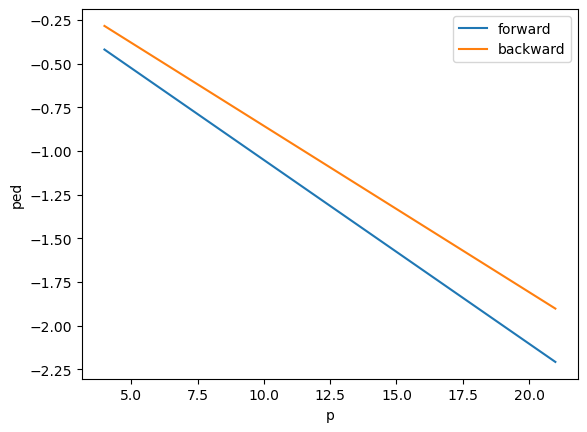

In [5]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .plot(kind='line', ylabel='ped')

## Arc elasticity

In [6]:
_temp3 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p'])
    )

In [7]:
_temp4 = df \
    .assign(
        q_n=lambda d: d['q'].shift(-1),
        p_n=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p']),
        p=lambda d: d['p_n']
    )

<Axes: xlabel='p', ylabel='ped'>

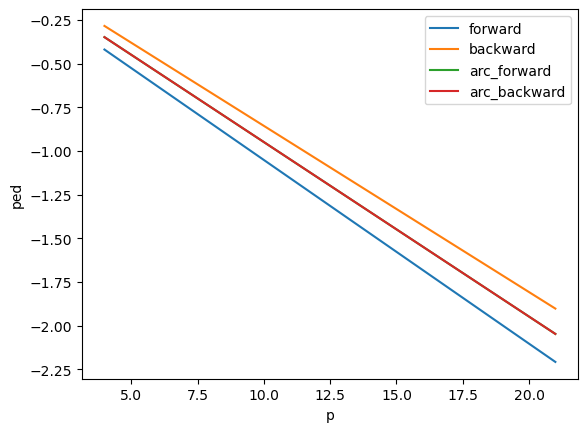

In [8]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .join(_temp3.set_index(['p']).rename(columns={'ped': 'arc_forward'})[['arc_forward']]) \
    .join(_temp4.set_index(['p']).rename(columns={'ped': 'arc_backward'})[['arc_backward']]) \
    .plot(kind='line', ylabel='ped')

In [9]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .join(_temp3.set_index(['p']).rename(columns={'ped': 'arc_forward'})[['arc_forward']]) \
    .join(_temp4.set_index(['p']).rename(columns={'ped': 'arc_backward'})[['arc_backward']])

,forward,backward,arc_forward,arc_backward
p,,,,
3.99,-0.419632,-0.284536,-0.348709,-0.348709
4.99,-0.524803,-0.379699,-0.448626,-0.448626
5.99,-0.629974,-0.474861,-0.548543,-0.548543
6.99,-0.735145,-0.570024,-0.648460,-0.648460
7.99,-0.840316,-0.665186,-0.748376,-0.748376
8.99,-0.945487,-0.760349,-0.848293,-0.848293
9.99,-1.050657,-0.855512,-0.948210,-0.948210
10.99,-1.155828,-0.950674,-1.048127,-1.048127
11.99,-1.260999,-1.045837,-1.148043,-1.148043


## All-pairs elasticity

In [10]:
p2q = {np.log(r['p']): np.log(r['q']) for _, r in df.iterrows()}

In [11]:
import itertools

price_pairs = np.log(df['p'].values)
price_pairs = itertools.product(price_pairs, price_pairs)
price_pairs = list(price_pairs)

len(price_pairs)

361

In [12]:
def compute_elasticity(p1, p2, q1, q2):
    a = (p1 + p2) / (q1 + q2)
    b = (q1 - q2) / (p1 - p2) if p1 != p2 else 0.01
    
    return a * b

In [13]:
ped_df = pd.DataFrame([(p1, p2, p2q[p1], p2q[p2], compute_elasticity(p1, p2, p2q[p1], p2q[p2])) 
                       for p1, p2 in price_pairs], columns=['p1', 'p2', 'q1', 'q2', 'ped'])

<Axes: xlabel='p1', ylabel='p2'>

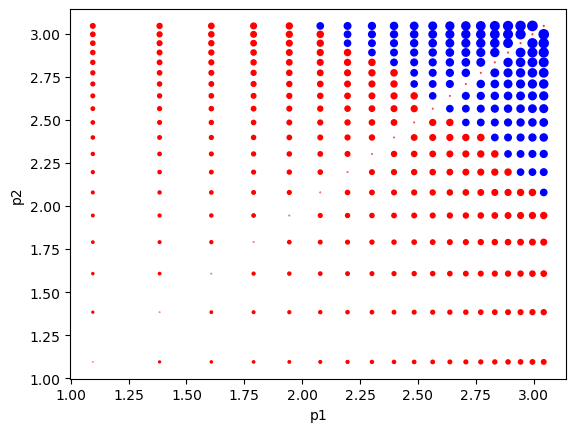

In [14]:
ped_df.assign(s=lambda d: np.abs(d['ped']) * 20) \
    .plot(
        kind='scatter', 
        x='p1', y='p2', s='s', 
        color=np.abs(ped_df['ped']).apply(lambda v: 'r' if v < 1 else 'b')
    )

In [15]:
from sklearn.linear_model import LinearRegression

Xy = np.log(df)
X = Xy[['p']]
y = Xy['q']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(5.847908050360597, array([-0.95402491]))

<Axes: xlabel='p'>

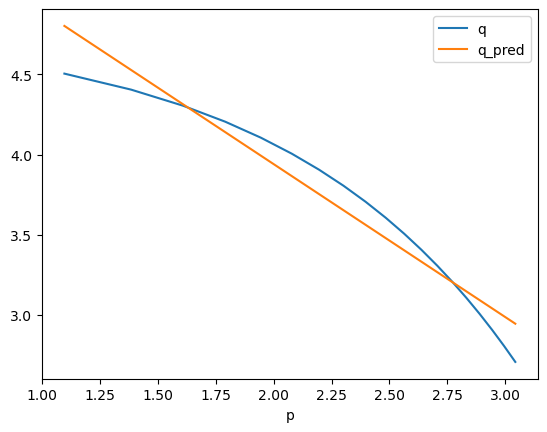

In [16]:
Xy.assign(q_pred=m.predict(X)).set_index(['p']).plot(kind='line')

In [17]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=5)
m.fit(X, y)

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [ ]:
Xy.assign(q_pred=m.predict(X)).set_index(['p']).plot(kind='line')